In [1]:
from functools import partial
import math
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import Tensor
import torch.nn as nn
import torch.utils.data as data

import pyro
import pyro.distributions as dist
import pyro.infer.autoguide as ag

import tyxe

from contbayes.BNN.BayesNN import FullCovBNN
from contbayes.Trackers.EKF import EKF

# Bayesian Continual Learning - Classification Example

## Problem Description

Consider a $\pi/4$-QPSK constellation in 2D. QPSK constellation can be seen in the figure below in blue and the $\pi/4$-QPSK constellation (rotated $45^{\circ}$ degrees clockwise) can be seen in green.

<div>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/a5/Pi-by-4-QPSK_Gray_Coded.svg/1280px-Pi-by-4-QPSK_Gray_Coded.svg.png" width="400"/>
</div>

We have four constellation points, $\sqrt{E_s}\text{exp}\left(j\frac{\pi(k + 2)}{2} \right)$ for $k=0,1,2,3$ representing `00`, `01`, `10` and `11` respectively.

We will assume additive white gaussian noise with zero mean - $\mathcal{N}\left(\boldsymbol{0}, \frac{1}{2}N_0\boldsymbol{I}_2\right)$.

The lower bound on the error rate, achieved by the MAP rule, is
$$P_e \geq 1 - \left(1 - Q\left(\sqrt{\frac{E_s}{N_0}}\right)\right)^2 = 1 - \left(1 - Q\left(\sqrt\frac{SNR}{2}\right)\right)^2$$
where $Q$ is the Q-function and the SNR is defined by
$$SNR = \frac{E_s}{\frac{1}{2}N_0} = \frac{2E_s}{N_0}$$

We'll choose $E_s = 2$ and $N_0 = 1/4$ giving $\text{SNR} = 16$.

The lower bound on the error is
$$P_e \geq 1 - (1 - Q(2\sqrt(2)))^2 = 0.00467 = 0.467\%$$

In [2]:
N_0 = 1/4
Es = 2

## Dynamics

The following class, `constellation_circle_dynsmics`, is able to produce samples while moving the constellation points counter-clockwise along a circle with radius $\sqrt{E_s}$.

The `speed` parameter defines how fast the model will move the constellation points. It will take $speed^{-1}$ time steps for each point to move to the location of the following point along the circle.

This way the error rate of the optimal decision rule (MAP) stays the same, because the distance between the constellation points is constant.

In [3]:
class ConstellationCircleDynamics:
    def __init__(self, n_points: int, noise_var:float, speed: float, energy: float, archive_path = False):
        self.n_points = n_points
        self.points = math.sqrt(energy) * torch.tensor([[math.cos(2 * math.pi * k / n_points + math.pi), math.sin(2 * math.pi * k / n_points + math.pi)] for k in range(n_points)])
        self.noise_var = noise_var
        self.speed = speed
        self.energy = energy
        self.time = 0
        self.archive_path = archive_path
        self.points_archive = self.points.unsqueeze(0)

    def generate_samples(self, n: int = 1, advance: bool = True, randomize_order: bool = False) -> tuple[Tensor, Tensor]:
        """
        :param n: number of samples to generate
        :param advance: advances the model to the next time step if True
        :param randomize_order: randomizes the order of the points sampled if True
        :return samples (n, 2): n / n_points samples from each constellation point
        """

        samples = math.sqrt(self.noise_var) * torch.randn(n, 2)

        if randomize_order:
            labels = torch.tensor(np.random.choice(a = self.n_points, size = n), dtype=torch.int64)
        else:
            labels = (torch.arange(n) * self.n_points) // n

        samples += self.points[labels]

        if advance:
            self.advance()

        return samples, labels

    def advance(self):
        self.time += 1
        self.points = math.sqrt(self.energy) * torch.tensor([[math.cos(2 * math.pi *  (k + self.speed * self.time) / self.n_points + math.pi), math.sin(2 * math.pi * (k + self.speed * self.time) / self.n_points + math.pi)] for k in range(self.n_points)])
        if self.archive_path:
            self.points_archive = torch.cat([self.points_archive, self.points.unsqueeze(0)])

Let us generate 1000 samples from each of our initial constellation points and plot the results on the 2D plane.

In [4]:
num_examples = 1000
dyn = ConstellationCircleDynamics(n_points = 4, noise_var = N_0 / 2, speed = 1e-3, energy = Es, archive_path = True)
x, y = dyn.generate_samples(4 * num_examples, advance=False)
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size = len(x) // 5)

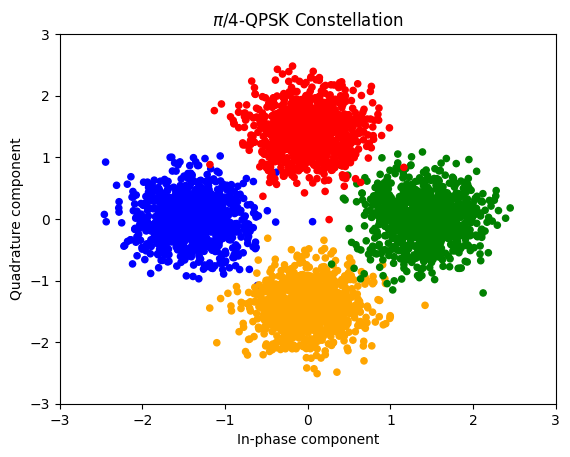

In [5]:
colors = ["blue", "orange", "green", "red"]
plt.scatter(x[..., 0], x[..., 1], s = 20, c = [colors[int(label)] for label in y])
plt.xlabel("In-phase component")
plt.ylabel("Quadrature component")
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title("$\pi/4$-QPSK Constellation")
plt.show()

Now let us continuously move the constellation points counter-clockwise along the circle with radius $\sqrt{E_s}$.

We've set the speed to $10^-3$, so it would take 1,000 iterations for each point to move to the initial location of the following point.

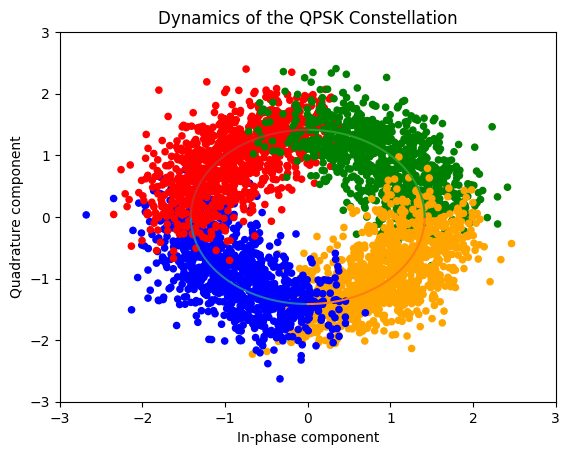

In [6]:
for i in range(1000):
    x_step, y_step = dyn.generate_samples(n = 4, randomize_order = True)
    colors = ["blue", "orange", "green", "red"]
    plt.scatter(x_step[..., 0], x_step[..., 1], s = 20, c = [colors[int(label)] for label in y_step])

for j in range(dyn.n_points):
    plt.plot(dyn.points_archive[...,j,0], dyn.points_archive[...,j,1])

plt.xlabel("In-phase component")
plt.ylabel("Quadrature component")
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.title("Dynamics of the QPSK Constellation")

plt.show()

## Training a Bayesian Neural Network

Network properties:

1. Small neural network with a single linear layer and sigmoid activation.

2. Prior of the weights is $\mathcal{N}(0,1)$ to keep them relatively small.

3. The posterior is a learnable Multivariate Normal distribution, where correlations are possible between all the weights.

In [7]:
loc = scale = scale_tril = None
assert loc is None
assert scale is None
assert scale_tril is None
trained = False

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 4)
        self.softmax = nn.Softmax(dim = -1)

    def forward(self, inputs):
        outputs = self.fc1(inputs)
        outputs = self.softmax(self.fc2(outputs))
        return outputs

prior = tyxe.priors.IIDPrior(dist.Normal(0, 1))
observation_model = tyxe.likelihoods.Categorical(dataset_size = len(loader.dataset), logit_predictions = False)
guide = partial(ag.AutoMultivariateNormal,
                init_scale=1e-4
)

BayesNN = FullCovBNN(model_type = "classifier",
                 output_dim = 4,
                 net_builder = Net,
                 prior = prior,
                 likelihood = observation_model,
                 guide_builder = guide)

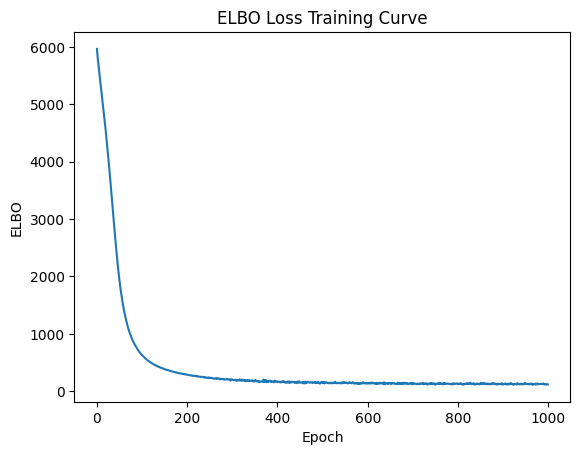

In [9]:
if trained:
    # BayesNN.predict(x[0])
    BayesNN.set_loc(loc)
    BayesNN.set_scale(scale)
    BayesNN.set_tril(scale_tril)
else:
    pyro.clear_param_store()
    param_store = pyro.get_param_store()
    optim = pyro.optim.Adam({"lr": 4e-3})
    elbos = []
    def callback(bnn, i, e):
        elbos.append(e)

    BayesNN.fit(loader, optim, 1000, callback)

    plt.plot(elbos)
    plt.xlabel("Epoch")
    plt.ylabel("ELBO")
    plt.title("ELBO Loss Training Curve")
    plt.show()

    loc = param_store.get_param('net_guide.loc').detach().clone()
    scale = param_store.get_param('net_guide.scale').detach().clone()
    scale_tril = param_store.get_param('net_guide.scale_tril').detach().clone()
    trained = True

We create the functions `test_model` and `plot_decision_zones` to test the model in terms of accuracy and confidence, and also plot the decision zones to visualize how the network performs the classification.

In [10]:
def test_model(model, inputs, labels):

    # Initialize lists to store true labels and predictions
    true_labels = []
    pred_labels = []
    probabilities = []

    # Run predictions
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        # Get the class with the highest probability
        output = model.predict(inputs, num_predictions = 32)
        probabilities.extend(output.max(-1).values.tolist())
        true_labels.extend(labels.squeeze().tolist())
        pred_labels.extend(output.argmax(-1).tolist())

    # Calculate accuracy
    accuracy = sum(1 for true, pred in zip(true_labels, pred_labels) if true == pred) / len(true_labels)

    # Calculate confidence
    confidence = sum(probabilities) / len(probabilities)

    return [accuracy, confidence]

def plot_decision_zones(model, inputs, labels, num_points):
    # Plot decision zones
    x_min, x_max = inputs[:, 0].min() - 0.1, inputs[:, 0].max() + 0.1
    y_min, y_max = inputs[:, 1].min() - 0.1, inputs[:, 1].max() + 0.1
    grid_size = max(abs(x_min), abs(y_min), abs(x_max), abs(y_max))
    xx, yy = np.meshgrid(np.arange(-grid_size, grid_size, 0.01),
                        np.arange(-grid_size, grid_size, 0.01))


    # Predict each point on the mesh (grid)
    grid_tensor = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    with torch.no_grad():
        grid_predictions = model.predict(grid_tensor, num_predictions = 32).argmax(-1).reshape(xx.shape)

    # Plot the decision boundary
    contour_colors = ["#1f77b4", "#1f77b4", "#ff7f0e", "#ff7f0e", "#2ca02c", "#2ca02c", "#d62728", "#d62728"]
    plt.contourf(xx, yy, grid_predictions.numpy(), alpha=0.7, colors = contour_colors[:2*num_points])
    scatter_colors = ["blue", "orange", "green", "red"]
    plt.scatter(inputs[..., 0], inputs[... , 1], edgecolors = "k", s = 20, c = [scatter_colors[int(l)] for l in labels])
    plt.title("Decision zones")
    plt.xlabel("In-phase component")
    plt.ylabel("Quadrature component")
    plt.xlim([-grid_size, grid_size])
    plt.ylim([-grid_size, grid_size])
    plt.show()

Accuracy: 0.9945
Confidence: 0.9913


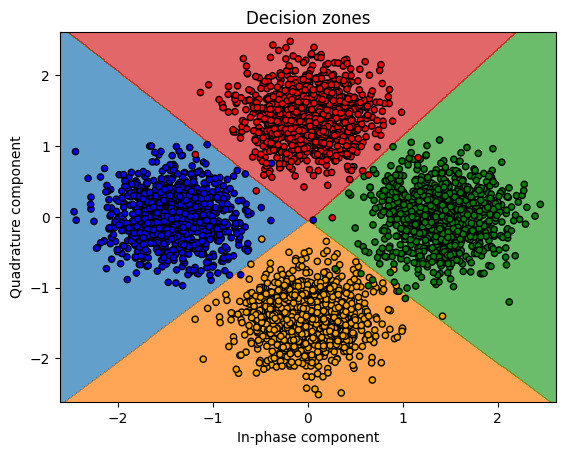

In [11]:
acc, conf = test_model(BayesNN, x, y)
print(f"Accuracy: {acc:.4f}")
print(f"Confidence: {conf:.4f}")
plot_decision_zones(BayesNN, x, y, 4)

## Tracking the Dynamics - Extended Kalman Filter

We have an observation model:
$$\boldsymbol{y}_{t}\sim Cat(h_{\theta_t}(x_t))$$
and the following assumption about state dynamics:
$$\boldsymbol{\theta}_{t} \sim \mathcal{N}(f\cdot \boldsymbol{\theta}_{t-1}, q\boldsymbol{I})$$
where choosing positive process noise variance $q > 0$ injects some noise at each time step to ensure the model does not lose "plasticity" and choosing a state decay coefficient $f < 1$ ensures the covariance of the weights does not blow up [1].

Since the observations have a categorical distribution, we need to make adaptations for the extended Kalman filter in order to apply it.

We will use the same approach used in [2], [3], assuming that $p(\boldsymbol{y}_t\mid \boldsymbol{\theta}_t, \boldsymbol{x}_t)=\text{expfam}(y_t\mid h_{\theta_t}(\boldsymbol{x}_t))$ is an exponential family distribution with mean parameter $h_{\theta_t}(\boldsymbol{x}_t)$.

We define the predicted observation to be $\boldsymbol{\hat y}_t=\mathbb{E}[h_{\theta_t}(\boldsymbol{x}_t)\mid \boldsymbol{y}_{1:t}]$ and the error term to be $\boldsymbol{e}_t=T(\boldsymbol{y}_t)-\boldsymbol{\hat y}_t$ where $T(\boldsymbol{y}_t)$ is the sufficient statistics vector. For classification with $k$ labels, we have $T(\boldsymbol{y}_t) = (\boldsymbol{1}_{y_t=1},\dots,\boldsymbol{1}_{y_t=k})$

Furthermore, the observation covariance is given by $\boldsymbol{R}_t=\text{Cov}(T(\boldsymbol{y}_t)\mid \boldsymbol{\hat y}_t)$. For classification with $k$ labels, we have $\boldsymbol{R}_t = diag(\boldsymbol{p}_t)-\boldsymbol{p}_t\boldsymbol{p}_t^T$ where $\boldsymbol{\hat y}_t = (p_t^1,\dots,p_t^k)$.

Due to the sum-to-one $\sum_{i=1}^{k}p_t^k = 1$, drop the last entry of $\boldsymbol{y}_t, \boldsymbol{\hat y}_t$ and the last row/column of $\boldsymbol{R}_t$ to get an invertible covariance matrix and avoid numerical problems.

In [12]:
dyn = ConstellationCircleDynamics(n_points = 4, noise_var = N_0 / 2, speed = 2e-4, energy = Es)

label_blocks = torch.zeros(0, 0)
receive_blocks = torch.zeros(0, 0)
for t in range(5000):
    rx, l = dyn.generate_samples(n = 64)
    label_blocks = l if t == 0 else torch.cat([label_blocks, l])
    receive_blocks = rx if t == 0 else torch.cat([receive_blocks, rx])

dataset = data.TensorDataset(receive_blocks, label_blocks)
loader = data.DataLoader(dataset, batch_size=64, shuffle=False)

In [13]:
Kalman_Filter = EKF(obs_model = BayesNN, state_model = 1, process_noise_var = 1e-4, obs_reduction='label')
Kalman_Filter.run(dataloader = loader, callback = None)

100%|██████████| 5000/5000 [01:14<00:00, 67.04it/s]

skipped 1/5000 iterations


Accuracy: 0.9952
Confidence: 0.9943


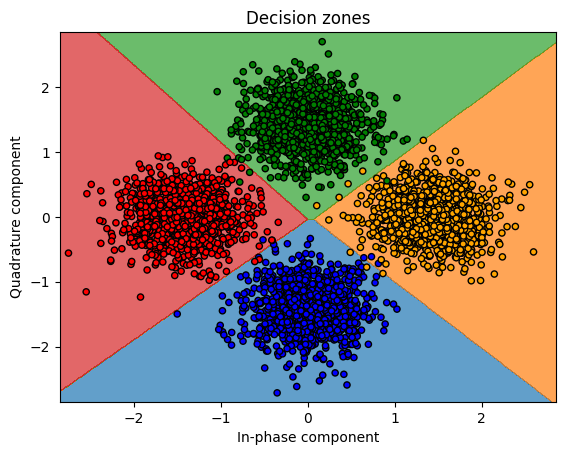

In [14]:
x_new, y_new = dyn.generate_samples(4 * num_examples, advance = False)

acc, conf = test_model(Kalman_Filter.obs_model, x_new, y_new)
print(f"Accuracy: {acc:.4f}")
print(f"Confidence: {conf:.4f}")
plot_decision_zones(Kalman_Filter.obs_model, x_new, y_new, 4)

As we can see, we have near optimal tracking results. The accuracy remains very close to the theoretical limit. The decision zones closely resemble the MAP rule decision zones.

## Bibliography
1. Peter G. Chang, Gerardo Duran-Martin, Alexander Y Shestopaloff, Matt Jones, and Kevin Murphy. Low-rank extended kalman filtering for online learning of neural networks from
streaming data. arXiv preprint arXiv:2305.19535, 2023.
2. Peter G Chang, Kevin Patrick Murphy, and Matt Jones. On diagonal approximations to the extended kalman filter for
online training of bayesian neural networks. In Continual Lifelong Learning Workshop at ACML 2022, December 2022.
3. Yann Ollivier. Online natural gradient as a kalman filter. Electron. J. Stat., 12(2):29302961, 2018.